In [1]:
from fore_utils import *

In [2]:
import torch
import torch.nn as nn
    
class TransformerModel(nn.Module):
    def __init__(self, window_size: int = 24, variables: int = 6, spaces: int = 0, d_model=64, nhead=8, num_layers=8, output_dim: int = 12):
        super(TransformerModel, self).__init__()

        input_dim = window_size * variables * spaces

        self.encoder = nn.Linear(input_dim, d_model)

        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)

        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        # print(x.shape)

        x = self.encoder(x)
        # print(x.shape)

        x = x.unsqueeze(1) 
        
        x = self.transformer_encoder(x)
        # print(x.shape)

        x = self.decoder(x.squeeze(1))
        # print(x.shape)
        
        return x


In [73]:
window_size = 5
steps = 24
spaces = 0
hidden_size = 32
batch_size = 64
n_heads = 4
num_layers = 8
series_target = True
lightning = True
verbose = True

config = {
    "hidden_layer_sizes": [hidden_size],
    "window_size" : [window_size],
    "step_size" : [steps],
    "spaces" : [spaces],
    "batch_size": [batch_size],
    "n_heads": [n_heads],
    "num_layers": [num_layers],
    "series_target": [series_target],
    "lightning": [lightning],
}

train_set = WeatherData(window_size=window_size, step_size=steps, set='train', spaces=spaces, lightning=lightning, series_target=series_target, verbose=verbose)
train_loader = DataLoader(train_set,
                           batch_size=batch_size, shuffle=True)
    
val_set = WeatherData(window_size=window_size, step_size=steps, set='val', spaces=spaces, lightning=lightning, series_target=series_target, verbose=verbose)
val_loader = DataLoader(val_set,
                           batch_size=batch_size, shuffle=False)


Details for train set:
Data from ['2018', '2019', '2020', '2021'] loaded
Features shape: torch.Size([35064, 6])
Targets shape: torch.Size([35064])
Longitudes: 18.3061580657959
Latitudes: -31.636999130249023
Details for val set:
Data from ['2022'] loaded
Features shape: torch.Size([8760, 6])
Targets shape: torch.Size([8760])
Longitudes: 18.3061580657959
Latitudes: -31.636999130249023


Input shape: torch.Size([64, 5, 6])
Target shape: torch.Size([64, 24])
Prediction shape: torch.Size([64, 24])
torch.Size([64, 5])


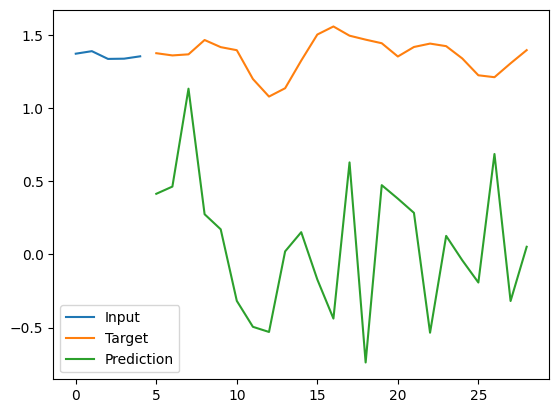

In [78]:
for batch in train_loader:
    x,b, y = batch
    break

model = TransformerModel(window_size=window_size, 
                            variables=6, 
                            spaces=1, 
                            d_model=hidden_size, 
                            nhead=n_heads, 
                            num_layers=num_layers, 
                            output_dim=steps)

model.to('cpu')

print('Input shape:', x.shape)
print('Target shape:', y.shape)


y_pred = model(x.float())

print('Prediction shape:', y_pred.shape)

print(b.shape)

plt.plot(np.arange(window_size), b[0].detach().numpy(), label='Input')
plt.plot(np.arange(window_size,window_size+steps), y[0].detach().numpy(),  label='Target')
plt.plot(np.arange(window_size,window_size+steps), y_pred[0].detach().numpy(), label='Prediction')

plt.legend()
plt.show()

In [79]:
# Hyperparameters
n_epochs = 100
warmup_epochs = 10
initial_lr = 1e-5
early_stopping_patience = 5
checkpoint_path = f'best_model_{window_size}_{hidden_size}_{steps}_{n_heads}_{num_layers}_spatial.pth'

wandb.init(project="time_series_forecasting", name=f'model_{window_size}_{hidden_size}_{steps}_spatial', config=config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
                         
train_model(model, train_loader, val_loader, n_epochs=n_epochs, warmup_epochs=warmup_epochs,
            initial_lr=initial_lr, early_stopping_patience=early_stopping_patience, checkpoint_path=checkpoint_path, device=device)



Epoch 0, Batch 0, Loss: 2.8695
Epoch 0, Batch 100, Loss: 2.3083
Epoch 0, Batch 200, Loss: 1.9017
Epoch 0, Batch 300, Loss: 1.8644
Epoch 0, Batch 400, Loss: 1.3493
Epoch 0, Batch 500, Loss: 1.5567
Epoch 0 Completed, Average Training Loss: 1.8971
Validation Loss after Epoch 0: 1.3086
Learning rate after Epoch 0: 0.000002
New best model saved with validation loss: 1.3086
Epoch 1, Batch 0, Loss: 1.4270
Epoch 1, Batch 100, Loss: 0.8641
Epoch 1, Batch 200, Loss: 0.7311
Epoch 1, Batch 300, Loss: 1.1017
Epoch 1, Batch 400, Loss: 0.9304
Epoch 1, Batch 500, Loss: 0.8313
Epoch 1 Completed, Average Training Loss: 1.0963
Validation Loss after Epoch 1: 0.9832
Learning rate after Epoch 1: 0.000003
New best model saved with validation loss: 0.9832
Epoch 2, Batch 0, Loss: 1.0036
Epoch 2, Batch 100, Loss: 0.8121
Epoch 2, Batch 200, Loss: 1.0144
Epoch 2, Batch 300, Loss: 1.0035
Epoch 2, Batch 400, Loss: 1.3014
Epoch 2, Batch 500, Loss: 0.9651
Epoch 2 Completed, Average Training Loss: 0.9644
Validation Lo

In [80]:
test_loader = DataLoader(WeatherData(window_size=window_size, step_size=steps, set='test', spaces=spaces, lightning=lightning, series_target=series_target, verbose=verbose),
                            batch_size=batch_size, shuffle=False)

model.load_state_dict(torch.load(checkpoint_path))
model.eval()

model.to(device)

test_loss = evaluate_model(model, test_loader, device)

print(f"Test loss: {test_loss}")

wandb.log({"test_loss": test_loss})

wandb.finish()

Details for test set:
Data from ['2023'] loaded
Features shape: torch.Size([8760, 6])
Targets shape: torch.Size([8760])
Longitudes: 18.3061580657959
Latitudes: -31.636999130249023
Test loss: 0.284002967613892


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
learning_rate,▁▂▃▄▅▆████████████████████████████████▄▄
test_loss,▁
train_loss,█▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,48
learning_rate,1e-05
test_loss,0.284
train_loss,0.26173
val_loss,0.27959


Input shape: torch.Size([64, 5, 6])
Target shape: torch.Size([64, 24])
Prediction shape: torch.Size([64, 24])


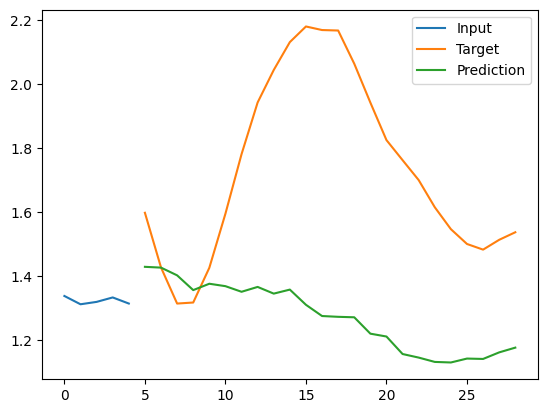

In [100]:
for batch in train_loader:
    x,b, y = batch
    break

model.to('cpu')

y_pred = model(x.float())

print('Input shape:', x.shape)
print('Target shape:', y.shape)
print('Prediction shape:', y_pred.shape)

plt.plot(np.arange(window_size), b[0].detach().numpy(), label='Input')
plt.plot(np.arange(window_size,window_size+steps), y[0].detach().numpy(),  label='Target')
plt.plot(np.arange(window_size,window_size+steps), y_pred[0].detach().numpy(), label='Prediction')

plt.legend()
plt.show()